# Galaxy Zoo with keras


Scroll down for the main keras code. The top section is for creating validation and sample data.

## Create Train/Test/Validation/Sample data

You can use the below code to help move files from the training folder to the validation folder, and to create a small amount of sample data for debugging. 

### Create validation data

In [2]:
import os
import numpy as np
import glob

In [3]:
data_path = 'data/'

# g = glob.glob(data_path+'train/*.jpg')
# shuf = np.random.permutation(g)
# for i in range(2000):
#     os.rename(shuf[i], data_path+ 'valid/' + shuf[i].split("/")[-1])

### Create sample data

In [4]:
# from shutil import copyfile

In [5]:
# Copy files into sample data

In [6]:
# g = glob.glob(data_path+"train/*.jpg") # find all path names matching this regex pattern
# shuf = np.random.permutation(g)
# for i in range(2000):
#     copyfile(shuf[i], data_path+"sample/train/" + shuf[i].split("/")[-1])

In [7]:
# valid_path = data_path + 'valid/'
# g = glob.glob(valid_path + '*.jpg') # find all path names matching this regex pattern
# shuf = np.random.permutation(g)
# for i in range(200):
#     copyfile(shuf[i], data_path+"sample/valid/" + shuf[i].split("/")[-1])

In [8]:
# test_path = data_path + 'test/'
# g = glob.glob(test_path + '*.jpg') # find all path names matching this regex pattern
# shuf = np.random.permutation(g)
# for i in range(2000):
#     copyfile(shuf[i], data_path+"sample/test/" + shuf[i].split("/")[-1])

# Build the model in keras

In [9]:
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda, Reshape
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.optimizers import SGD, RMSprop, Adam

import matplotlib.pylab as plt
%matplotlib inline

In [10]:
def ConvBlock(layers, model, filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))  # zero padding of size 1
        model.add(Convolution2D(filters, 3, 3, activation='relu'))  # 3x3 filter size 
    model.add(MaxPooling2D((2,2), strides=(2,2)))

def FCBlock(model):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def VGG_16():
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(3,106,106)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(37, activation = 'sigmoid'))
    return model

# Compile 
optimizer = RMSprop(lr=1e-6)
model = VGG_16()
model.compile(loss='mean_squared_error', optimizer=optimizer)

/home/james/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 106, 106)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/home/james/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1811: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_1_model" was not an Input tensor, it was generated by layer lambda_1.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: lambda_input_1
  str(x.name))


In [12]:
from random import shuffle
from scipy.misc import imresize  

class data_getter:    
    """
    Creates a class for handling train/valid/test data paths,
    training labels and image IDs.
    Useful for switching between sample and full datasets.
    """
    def __init__(self, path):    
        self.path = path 
        self.train_path = path + "train"
        self.val_path = path + "valid"
        self.test_path = path + "test"
        
        def get_paths(directory):
            return [f for f in os.listdir(directory)]
        
        self.training_images_paths = get_paths(self.train_path)
        self.validation_images_paths = get_paths(self.val_path)
        self.test_images_paths = get_paths(self.test_path)    
        
        def get_all_solutions():
        ### Import solutions file and load into self.solutions
            import csv
            all_solutions = {}
            with open('training_solutions_rev1.csv', 'r') as f:
                reader = csv.reader(f, delimiter=",")
                next(reader)
                for i, line in enumerate(reader):
                    all_solutions[line[0]] = [float(x) for x in line[1:]]
            return all_solutions
        
        self.all_solutions = get_all_solutions()

    def get_id(self,fname):
        return fname.replace(".jpg","").replace("data","")
        
    def find_label(self,val):
        return self.all_solutions[val]
        
# fetcher = data_getter('data/sample/')
fetcher = data_getter('data/')
print(fetcher.train_path)

data/train


In [13]:
def process_images(paths):
    """
    Import image at 'paths', decode, centre crop and prepare for batching. 
    """
    count = len(paths)
    arr = np.zeros(shape=(count,3,106,106))
    for c, path in enumerate(paths):
        img = plt.imread(path).T
        img = img[:,106:106*3,106:106*3] #crop 424x424 -> 212x212
        img = imresize(img,size=(106,106,3),interp="cubic").T # downsample to half res
        arr[c] = img
    return arr

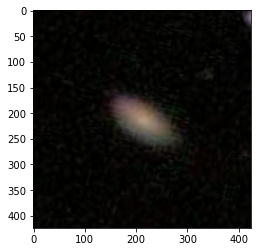

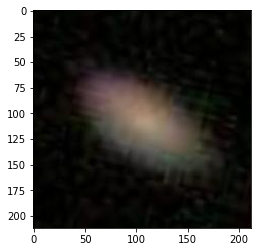

In [47]:
## Print some before/after processing images

#process_images([fetcher.train_path + '/' + fetcher.training_images_paths[100]])
im = plt.imread(fetcher.train_path + '/' + fetcher.training_images_paths[0])
# print(im.shape)

plt.imshow(im)
plt.show()
im = im.T[:,106:106*3,106:106*3] #crop 424x424 -> 212x212
# im = imresize(im,size=(106,106,3),interp="cubic").T # downsample to half res
# print(im.shape)
plt.imshow(im.T)

In [15]:
# Create generator that yields (current features X, current labels y)
def BatchGenerator(getter):
    while 1:
        for f in getter.training_images_paths:
            X_train = process_images([getter.train_path + '/' + fname for fname in [f]])
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)
            
def ValBatchGenerator(getter):
    while 1:
        for f in getter.validation_images_paths:
            X_train = process_images([getter.val_path + '/' + fname for fname in [f]])
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)
                        

### Train model

In [27]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
    
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='tmp/weights.hdf5', verbose=1, save_best_only=True)


batch_size = 32
steps_to_take = int(len(fetcher.training_images_paths)/batch_size)
val_steps_to_take = int(len(fetcher.validation_images_paths)/batch_size)
                #typically be equal to the number of unique samples if your dataset
                #divided by the batch size.
        
        
model = load_model('tmp/weights.hdf5')

hist = model.fit_generator(BatchGenerator(fetcher),
                    samples_per_epoch=steps_to_take, 
                    nb_epoch=50,
                    validation_data=ValBatchGenerator(fetcher),
                    nb_val_samples=val_steps_to_take,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                   )

/home/james/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1811: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_2_model" was not an Input tensor, it was generated by layer lambda_1.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: lambda_input_2
  str(x.name))


Epoch 1/50
Epoch 00000: val_loss improved from inf to 0.01857, saving model to tmp/weights.hdf5
142s - loss: 0.0181 - val_loss: 0.0186
Epoch 2/50
Epoch 00001: val_loss improved from 0.01857 to 0.01643, saving model to tmp/weights.hdf5
139s - loss: 0.0180 - val_loss: 0.0164
Epoch 3/50


KeyboardInterrupt: 

### Plot training/validation loss

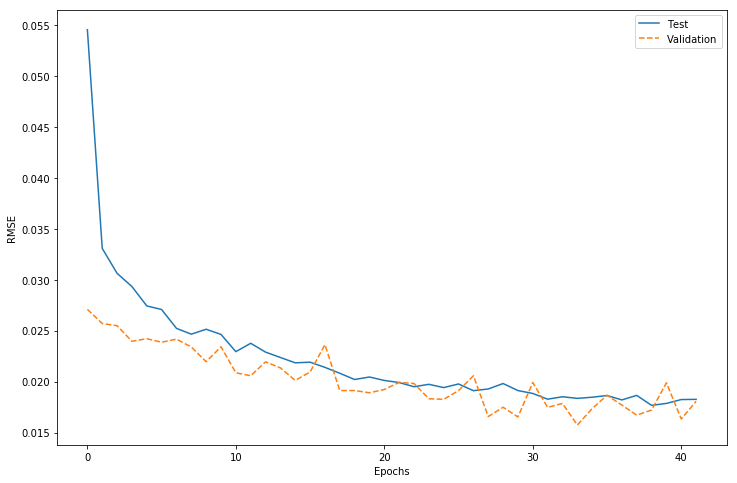

In [56]:
plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],label='Test')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### Model Predict

In [ ]:
# Load best model weights
from keras.models import load_model
model = load_model('tmp/weights.hdf5')

In [ ]:
def TestBatchGenerator(getter):
    while 1:
        for f in getter.test_images_paths:
            X_train = process_images([getter.test_path + '/' + fname for fname in [f]])
            yield (X_train)

predictions = model.predict_generator(TestBatchGenerator(fetcher),
                       val_samples = len(fetcher.test_images_paths),
                        max_q_size = 32,)

In [ ]:
predictions.shape

In [ ]:
header = open('all_zeros_benchmark.csv','r').readlines()[0]

with open('submission_1.csv','w') as outfile:
    outfile.write(header)
    for i in range(len(fetcher.test_images_paths)):
        id_ = (fetcher.get_id(fetcher.test_images_paths[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")